In [312]:
import numpy as np 
import pandas as pd 

In [313]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-313-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Read Data

In [314]:
url = 'https://git.uwaterloo.ca/ky5liu/680-project/-/raw/main/training.1600000.processed.noemoticon.csv'
columns = ["label", "ids", "date", "flag", "user", "Text"]
df = pd.read_csv(url, encoding = "ISO-8859-1", names=columns)

In [315]:
df.set_index('ids',inplace = True)

In [316]:
df.label.value_counts()
df.head()

,label,date,flag,user,Text
ids,,,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [317]:
possible_label = df.label.unique()
dict_label = {}
for index,possible_label in enumerate(possible_label):
    dict_label[possible_label] = index
dict_label

{0: 0, 4: 1}

0:0 negative
4:1 positive

New column of label to represent emotion

In [318]:
df["label"] = df["label"].replace(dict_label)

Drop columns that are not useful


In [319]:
df=df.drop(columns=[ "flag", "user"], axis = 1)
df.head()


,label,date,Text
ids,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Removing hyperlinks

In [320]:
df["Text"] = df["Text"].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df.head()

,label,date,Text
ids,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,@switchfoot - A that's a bummer. You shoulda got David Carr of Third Day to do it. ;D
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Run Before here for BERT

Convert string date to date time type

In [321]:
df['date']= pd.to_datetime(df['date']).dt.date
print(df['date'].min())
print(df['date'].max())

/usr/local/lib/python3.8/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


2009-04-06
2009-06-25


The earliest tweet is Fri Apr 06 2009

The latest tweet is Fri June 26 2009

Getting files ready

In [322]:
import numpy as np 
import pandas as pd 
import torch
from tqdm.notebook import tqdm
import random

#Naive-Bayes

In [323]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
def nb_clf(X_train, y_train, X_test, y_test, alpha_val=1):
  clf = MultinomialNB(alpha=alpha_val)
  clf.fit(X_train, y_train)
  prediction = clf.predict(X_test)
  accuracy = metrics.accuracy_score(y_test,np.array(prediction))
  return prediction,accuracy

In [324]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df[["Text","date"]],
                                                df.label,
                                                test_size = 0.15,
                                                random_state=680,
                                                stratify = df.label.values)

In [325]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.Text)
# X_train_counts.shape
X_test_counts = count_vect.transform(X_test.Text)
# X_test_counts.shape

CPU times: user 26 s, sys: 241 ms, total: 26.2 s
Wall time: 26.2 s


In [326]:
%%time
prediction,accuracy = nb_clf(X_train=X_train_counts, y_train=y_train, X_test=X_test_counts, y_test=y_test)
print(accuracy)
y_test

0.7844291666666666
CPU times: user 582 ms, sys: 1.93 ms, total: 584 ms
Wall time: 582 ms


ids
2288755677    0
2047688718    0
1823041576    0
1972898288    1
1978965583    1
             ..
2061573783    1
2180255348    0
2196634248    0
2324701993    0
1977018153    1
Name: label, Length: 240000, dtype: int64

In [327]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

negative_words = " ".join(i for i in X_test[y_test == 0]['Text'])
pred_negative_words = " ".join(i for i in X_test[prediction == 0]['Text'])

stopwords = set(STOPWORDS)
neg_word = WordCloud(stopwords=stopwords,collocations = True,
                      background_color="white", colormap = "summer").generate(negative_words)
neg_word_pred = WordCloud(stopwords=stopwords,collocations = True,
                      background_color="white", colormap = "autumn").generate(pred_negative_words)

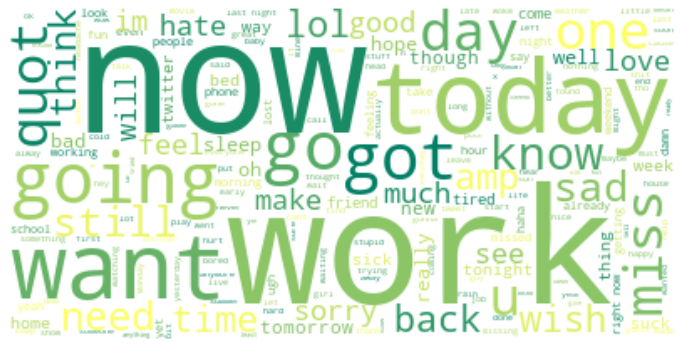

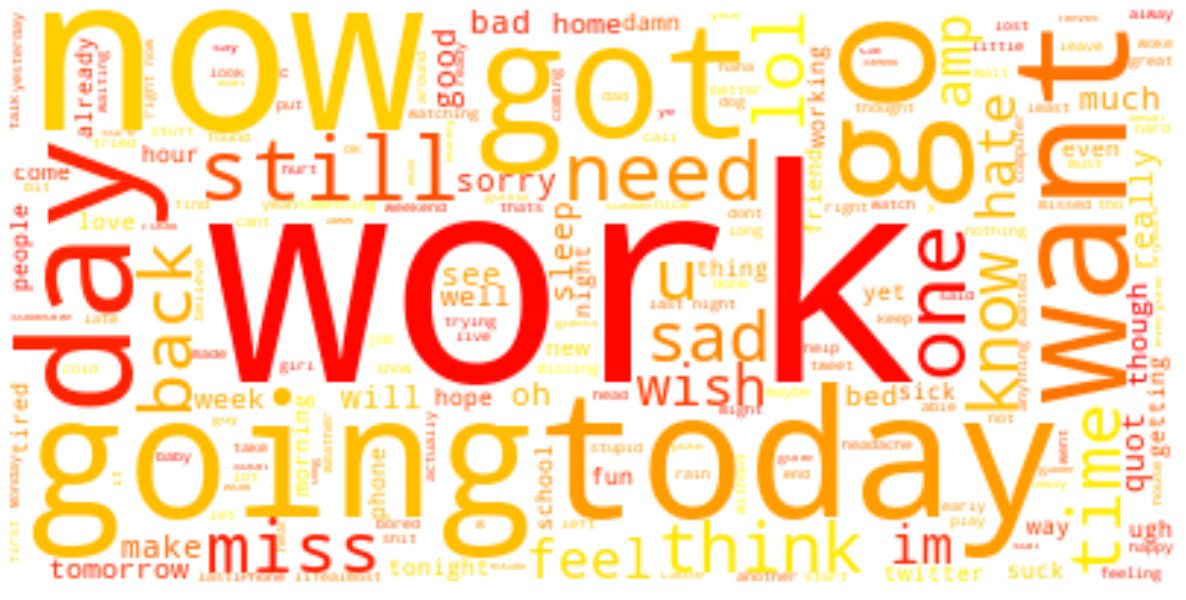

In [328]:
plt.figure(figsize=(12,9))
plt.imshow(neg_word, interpolation='bilinear')
plt.axis("off")
# plt.savefig('word_cloud.png')
plt.show()

plt.figure(figsize=(21,14))
plt.imshow(neg_word_pred, interpolation='bilinear')
plt.axis("off")
# plt.savefig('word_cloud_pred.png')
plt.show()

## Hyperparameter tuning - alpha

In [329]:
%%time

alpha_list = np.arange(start=1e-3,stop=1,step=1e-2)
len(alpha_list)
acc_list = []
for i in alpha_list:
  _,accuracy = nb_clf(X_train=X_train_counts, y_train=y_train, X_test=X_test_counts, y_test=y_test, alpha_val=i)
  acc_list.append(accuracy)

CPU times: user 51.8 s, sys: 316 ms, total: 52.1 s
Wall time: 52 s


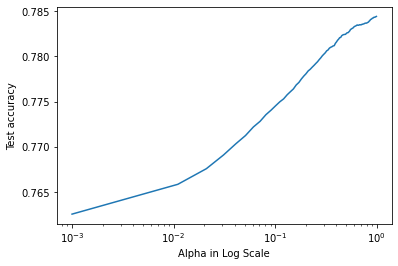

In [330]:
import matplotlib.pyplot as plt
acc_list.index((max(acc_list)))
plt.plot(alpha_list,acc_list)
plt.xscale('log')
plt.xlabel("Alpha in Log Scale")
plt.ylabel("Test accuracy")
plt.show()

Conclusion: alpha value = 1 yields the highest accuracy

##Stock data analysis

In [229]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
url = 'https://git.uwaterloo.ca/ky5liu/680-project/-/raw/main/sp500_delta_price.csv'
delta_price = pd.read_csv(url)
delta_price['date']= pd.to_datetime(delta_price['date']).dt.date
delta_price

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
import datetime  
#df_analysis needs date, label columns
def tweet_stock_corr(df_analysis, delta_price ):
  def intersection(nums1, nums2):
    set1 = set(nums1)
    set2 = set(nums2)
    return list(set2 & set1)

  # remove date after
  # organize date for two dataset
  dates_intersection = intersection(df_analysis['date'].values,delta_price['date'].values)
  dates_intersection.sort()

  delta_price = delta_price[delta_price['date'].isin(dates_intersection)]
  #only include rows with dates in intersection
  df_analysis = df_analysis[df_analysis['date'].isin(dates_intersection)]

  #count for tweets comments emotion each day
  df_analysis = df_analysis.groupby(['date', 'label']).size()
  #count tweet comments by positive and negative
  ratio = [(b-a)/(a+b) for a, b in zip(df_analysis[::2], df_analysis[1::2])]
  
  #correlation calculation   
  np.corrcoef(ratio[:-1], delta_price.delta_price[:-1])
  corr = (pearsonr(ratio,delta_price.delta_price)[0],np.corrcoef(ratio, delta_price.delta_price))

  

  #graph
  fig, ax1 = plt.subplots()

  color = 'tab:green'
  ax1.set_xlabel('date')
  ax1.set_ylabel('growth in ratio', color=color)
  p1, = ax1.plot(dates_intersection[:-1], delta_price.delta_price[:-1], color=color, label="Stock")
  ax1.tick_params(axis='y', labelcolor=color)
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('ratio in tweets polarity', color=color)  # we already handled the x-label with ax1
  p2, = ax2.plot(dates_intersection[:-1], ratio[:-1], color=color, label="Tweets")
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_xticks( [dates_intersection[2],dates_intersection[7],dates_intersection[18]] )
  # fig.tight_layout()  # otherwise the right y-label is slightly clipped
  ax2.legend(handles=[p1,p2])

  plt.show()

  return corr[0]

In [ ]:

df_analysis = df.copy()
df_analysis=df_analysis.drop(columns=["Text"], axis = 1)

#problem with the dataset, no positive comments after june 16
df_analysis = df_analysis[(df_analysis['date'] < datetime.date(year=2009,month=6,day=17))]

In [258]:
test = pd.DataFrame()
test['date'] = dates_intersection
test['ratio'] = ratio
test["delta_price"]= list(delta_price.delta_price)

grangercausalitytests(test[['delta_price', 'ratio',]], maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1121  , p=0.9516  , df_denom=14, df_num=3
ssr based chi2 test:   chi2=0.5044  , p=0.9179  , df=3
likelihood ratio test: chi2=0.4984  , p=0.9192  , df=3
parameter F test:         F=0.1121  , p=0.9516  , df_denom=14, df_num=3


{3: ({'ssr_ftest': (0.11208624872146844, 0.951593480795042, 14.0, 3),
   'ssr_chi2test': (0.504388119246608, 0.9179263087722677, 3),
   'lrtest': (0.498426078244961, 0.9192370591001404, 3),
   'params_ftest': (0.11208624872146859, 0.951593480795042, 14.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

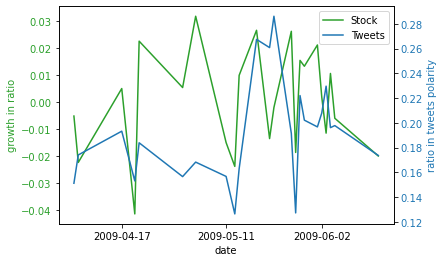

0.2732917836720452

In [ ]:
tweet_stock_corr(df_analysis, delta_price)

###Using Naive Bayes classifier in test set and compare with stock trend

In [297]:
def intersection(nums1, nums2):
    set1 = set(nums1)
    set2 = set(nums2)
    return list(set2 & set1)

In [301]:
dates_intersection = intersection(X_test['date'].values,
                                  delta_price['date'].values)
dates_intersection.sort()

,Text,date
ids,,
2288755677,"@erichalvorsen unfortunately, I am nowhere near a computer. it's actually really frustrating",2009-06-22
2047688718,Start of Prototype game ad just triggered me,2009-06-05
1823041576,"I love the short video Validation! It is a must see... Wow i really hate twitter, there is really not enought people that I know on it.",2009-05-16
1972898288,Hi people who arnt my followers......your going to be very sick of me by this time tomorrow,2009-05-30
1978965583,@bootooyoo Ooooh nice! Yours? Rented? Mates? Details!,2009-05-31
...,...,...
2061573783,Listening to tv on the radio on snl,2009-06-06
2180255348,Now that I've set a facebook username. I feel the pressure to clear my account of personal stuff and make it pure professional.,2009-06-15
2196634248,Lovely day of shopping with the hubby! So sad he has to go back to rainy new york!,2009-06-16


In [298]:
delta_price = delta_price[delta_price['date'].isin(dates_intersection)]


In [299]:
df_analysis = pd.DataFrame()
df_analysis['label'] = prediction
df_analysis['date'] = X_test['date'].values

#only include rows with dates in intersection
df_analysis = df_analysis[df_analysis['date'].isin(dates_intersection)]

df_analysis = df_analysis.groupby(['date', 'label']).size()
ratio = [(b-a)/(a+b) for a, b in zip(df_analysis[::2], df_analysis[1::2])]

In [309]:
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr   
np.corrcoef(ratio, delta_price.delta_price)
print(pearsonr(ratio,delta_price.delta_price)[0])


0.3334558879584085


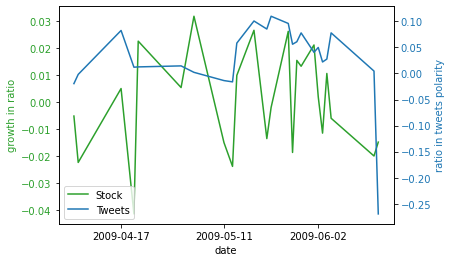

In [307]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('date')
ax1.set_ylabel('growth in ratio', color=color)
p1, = ax1.plot(dates_intersection, delta_price.delta_price, color=color, label="Stock")
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ratio in tweets polarity', color=color)  # we already handled the x-label with ax1
p2, = ax2.plot(dates_intersection[:-6], ratio, color=color, label="Tweets")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks( [dates_intersection[2],dates_intersection[7],dates_intersection[18]] )
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(handles=[p1,p2])


plt.show()

In [310]:
test = pd.DataFrame()
test['date'] = dates_intersection
test['ratio'] = ratio
test["delta_price"]= list(delta_price.delta_price)

grangercausalitytests(test[['delta_price', 'ratio',]], maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9545  , p=0.4412  , df_denom=14, df_num=3
ssr based chi2 test:   chi2=4.2954  , p=0.2313  , df=3
likelihood ratio test: chi2=3.9081  , p=0.2716  , df=3
parameter F test:         F=0.9545  , p=0.4412  , df_denom=14, df_num=3


{3: ({'ssr_ftest': (0.9545316232718257, 0.441190654799545, 14.0, 3),
   'ssr_chi2test': (4.295392304723216, 0.2312831531241584, 3),
   'lrtest': (3.9080962006969457, 0.2715606173567247, 3),
   'params_ftest': (0.9545316232718261, 0.441190654799545, 14.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

#BERT

Sample Size

Set sample size to 5000 or any other numbers

In [ ]:
import random
random.seed(680)
df_subset = df.sample(n = 5000, replace = False)
df_subset=df_subset.drop(columns=[ "date"], axis = 1)
# df_subset['date']= pd.to_datetime(df_subset ['date']).dt.date

,label,Text,data_type
ids,,,
1932802461,1,"@Jessi_lea I love ebay very addictive, do you shop on the Aus one or US ?",test
1972277915,1,@saaaaaarah15 its cool,train
1986006816,1,CONAN! I LOVE YOU AND CANNOT WAIT UNTIL MONDAY NIGHT!,train
2301883870,0,@tommcfly make a song dedicated to brazil please,train
2064595701,1,Well done Jenson &amp; everyone @officialbrawngp,train
...,...,...,...
1971386412,0,"@SarahMag80 oh man that is gonna be so nice a nice sea breeze to cool you off, toiling in the garden in this weather is not ideal",train
1558014960,0,My ribs are itching. Wahhh?,test
2296333260,0,its way too hot today,train


Train Test Split

In [ ]:
 from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_subset.index.values,
                                                df_subset.label.values,
                                                test_size = 0.15,
                                                random_state=680,
                                                stratify = df_subset.label.values)

Give new column name to dataset

In [ ]:
df_subset.loc[X_train,'data_type'] = 'train'
df_subset.loc[X_test,'data_type'] = 'test'

Modeling

In [ ]:
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


BERT tokenizer
- Edit this for other tokenzier options
https://huggingface.co/docs/transformers/main_classes/tokenizer#:~:text=%E2%80%9CFast%E2%80%9D%20implementation

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)
tokenizer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

https://huggingface.co/docs/transformers/v4.24.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.batch_encode_plus

In [ ]:
%%time
encoder_train = tokenizer.batch_encode_plus(df_subset[df_subset["data_type"]=='train'].Text.values,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(df_subset[df_subset["data_type"]=='test'].Text.values,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
#List of indices specifying which tokens should be attended to by the model 
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(df_subset[df_subset['data_type']=='train'].label.values)
# df[df['data_type']=='train'].label.value_counts()

input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(df_subset[df_subset['data_type']=='test'].label.values)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


CPU times: user 2.5 s, sys: 15.6 ms, total: 2.51 s
Wall time: 2.52 s


In [ ]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

Functions for model performance

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')


###############################################

def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")
###############################################

def acc_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat,preds_flat)

In [ ]:
seed_val = 680
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

##Model

### Batch size


Load data from encoded data

- tuning batch size, higher requires gpu, but faster
  - 16, 32 originally
  - 1000,1000 out of memory

In [ ]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader

dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16
    
)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32
    
)

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = len(dict_label),
                                     output_attentions = False,
                                     output_hidden_states =  False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Epoch and Optimizer

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)

epochs  = 2
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs 
)

Using GPU


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

Loading:cpu


Predict Function

In [ ]:
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        
    loss_val_avg = loss_val_total/len(dataloader_val)  
    
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,predictions,true_vals

Cross entropy loss is used for loss since we have a binary classification problem

https://stackoverflow.com/questions/71581197/what-is-the-loss-function-used-in-trainer-from-the-transformers-library-of-huggi

In [ ]:
%%time
for epoch in tqdm(range(1,epochs+1)):
    model.train()
    
    loss_train_total=0
    
    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)
    
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]
            
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
#     torch.save(model.state_dict(),f'/output/BERT_ft_epoch{epoch}.model')To save the model after each epoch
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}\f Train Accuracy')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    test_acc = acc_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test F1 Score:{test_score}\n Test Accuracy:{test_acc}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/266 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
val_loss,predictions,true_vals = evaluate(dataloader_test)

predictions
np.argmax(predictions,axis=1).flatten()
labels_flat = true_vals.flatten()
labels_flat


array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,